In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from keras.applications import resnet
import os
from PIL import Image

In [20]:
TRAINING_DIR = "./in/train"
OUT_WEIGHTS = "out/pepe-weights.h5"
OUT_MODEL = "out/pepe-model.tf"

image_size = (224, 224)
batch_size = 32

In [4]:
def rewrite_gif_to_png(file_path):
    new_file_path = os.path.splitext(file_path)[0] + ".png"
        
    img = Image.open(file_path)
    img.save(new_file_path, optimize=True)
    img.close()

    os.remove(file_path)

In [5]:
for category in os.listdir(TRAINING_DIR):
    cat_path = os.path.join(TRAINING_DIR, category)
    
    for f in os.listdir(cat_path):
        if (f[-4:] != ".gif"):
            continue
    
        file_path = os.path.join(cat_path, f)
        rewrite_gif_to_png(file_path)

In [6]:
ds = tf.keras.preprocessing.image_dataset_from_directory(TRAINING_DIR, labels="inferred", image_size=image_size, batch_size=batch_size)

Found 6853 files belonging to 2 classes.


2023-08-02 23:35:06.954558: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-02 23:35:06.955081: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


2023-08-02 23:35:10.829728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-02 23:35:11.656724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-02 23:35:11.656794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-08-02 23:35:11.656816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-02 23:35:11.871830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'desc': ICC profile tag start not a multiple of 4
2023-08-02 23:35:11.872116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'wtpt': ICC profile tag start not a multiple of 4
2023-08-02 23:35:11.872161: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'bkpt': ICC profile tag start not a multiple of 4
2023-08-02 23:35:11.872173: W tensorflow/core/lib/png/

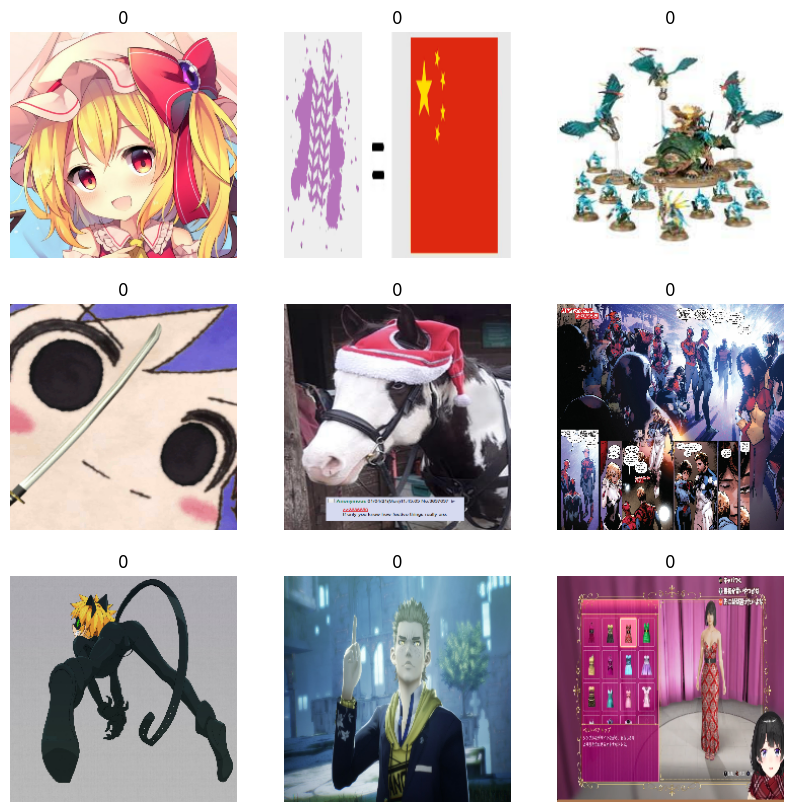

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [8]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [9]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)
    x = resnet.preprocess_input(x)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)

In [10]:
if (os.path.isfile(OUT_WEIGHTS)):
    model.load_weights(OUT_WEIGHTS)

In [11]:
epochs = 5

callbacks = [
    keras.callbacks.ModelCheckpoint("models/backup/save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(ds, epochs=epochs, callbacks=callbacks)

model.save_weights(OUT_WEIGHTS)

Epoch 1/5


2023-08-02 23:35:32.324083: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-02 23:35:33.136227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-02 23:35:33.136841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-08-02 23:35:33.136892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-02 23:35:33.340760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'desc': ICC profile tag start not a multiple of 4
2023-08-02 23:35:33.341232: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'wtpt': ICC profile tag start not a multiple of 4
2023-08-02 23:35:33.341259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'bkpt': ICC profile tag start not a multiple of 4
2023-08-02 23:35:33.341267: W tensorflow/core/lib/png/

  3/215 [..............................] - ETA: 10:16 - loss: 0.0037 - accuracy: 1.0000

2023-08-02 23:35:42.324874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/215 [..............................] - ETA: 10:10 - loss: 0.0096 - accuracy: 0.9922

2023-08-02 23:35:45.199954: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-02 23:35:45.221630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/215 [..............................] - ETA: 10:11 - loss: 0.0079 - accuracy: 0.9937

2023-08-02 23:35:48.154298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: sBIT: invalid


  8/215 [>.............................] - ETA: 10:00 - loss: 0.0085 - accuracy: 0.9922

2023-08-02 23:35:56.815280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/215 [>.............................] - ETA: 9:49 - loss: 0.0093 - accuracy: 0.9928

2023-08-02 23:36:11.520592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-02 23:36:11.520874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


 14/215 [>.............................] - ETA: 9:45 - loss: 0.0250 - accuracy: 0.9911

2023-08-02 23:36:14.427006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 18/215 [=>............................] - ETA: 9:33 - loss: 0.0293 - accuracy: 0.9913

2023-08-02 23:36:25.985094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/215 [=>............................] - ETA: 9:26 - loss: 0.0276 - accuracy: 0.9922

KeyboardInterrupt: 

In [13]:
img = keras.preprocessing.image.load_img("./in/train/pepe/1640970327516.jpg", target_size=image_size)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
score

1/1 [==============================] - 0s 254ms/step


array([0.865549], dtype=float32)

In [22]:
model.save(OUT_MODEL, True)

INFO:tensorflow:Assets written to: out/pepe-model.tf/assets


INFO:tensorflow:Assets written to: out/pepe-model.tf/assets
